In [1]:
# Install libraries
#install.packages("pROC")
#install.packages("vctrs")
#install.packages("caret")
#install.packages("nnet")
#install.packages("ggplot2")
#install.packages("cowplot")
#install.packages("dplyr")
#install.packages("glmnet")
#install.packages("knitr")

# Load libraries
library(pROC)
library(vctrs)
library(caret)
library(nnet)
library(ggplot2)
library(cowplot)
library(dplyr)
library(glmnet)
library(knitr)

Warning message:
"package 'pROC' was built under R version 4.3.3"
Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Warning message:
"package 'vctrs' was built under R version 4.3.3"
Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Loading required package: lattice

Warning message:
"package 'nnet' was built under R version 4.3.3"
Warning message:
"package 'cowplot' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following object is masked from 'package:vctrs':

    data_frame


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'glmnet' was

In [2]:
rm(list=ls()) #clears the workspace
data <- read.csv("SEIFA_RTT_LGA.csv")

# Remove rows with NAs in important percentile columns
cleaned_data <- data[complete.cases(data), ]

print(colnames(cleaned_data))

 [1] "lga_code"                  "IRSD.Decile"              
 [3] "IRSAD.Decile"              "IER.Decile"               
 [5] "IEO.Decile"                "Median.Income"            
 [7] "Lowest.Quartile.Income.."  "Highest.Quartile.Income.."
 [9] "Gini.Coefficient"          "Area..Km.2."              
[11] "Population"                "Population.Density"       
[13] "Population.Change"         "Population.Change.."      
[15] "Indigenous.Population"     "Indigenous.Population.."  
[17] "X5th.Percentile"           "X50th.Percentile"         
[19] "X95th.Percentile"          "X95th.5th.Ratio"          
[21] "major_city_distance"       "closest_capital_distance" 
[23] "own_capital_distance"      "Major.City"               
[25] "Inner.Regional"            "Outer.Regional"           
[27] "Remote"                    "Very.Remote"              
[29] "Division"                  "Previous.Party"           
[31] "Previous.Seat.Status"      "Successful.Party"         
[33] "Current.Seat.Statu

In [3]:
print('Number of rows in cleaned data:')
print(nrow(cleaned_data))

[1] "Number of rows in cleaned data:"
[1] 401


# BIG regression
### fit with all variables

## Begin Fitting

In [4]:
urban_data <- cleaned_data[(cleaned_data$Major.City == 1) | (cleaned_data$Inner.Regional == 1), ]
rural_data <- cleaned_data[(cleaned_data$Major.City == 0) & (cleaned_data$Inner.Regional == 0), ]

In [5]:
cor_matrix <- cor(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")
#cor_matrix

#write.csv(cor_matrix, file = "correlation_matrix.csv", row.names = FALSE)

urban_cor_matrix <- cor(urban_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(urban_cor_matrix, file = "urban_correlation_matrix.csv", row.names = FALSE)

# rural correlation matrix
rural_cor_matrix <- cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(rural_cor_matrix, file = "rural_correlation_matrix.csv", row.names = FALSE)


Warning message in cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile", :
"the standard deviation is zero"


In [7]:
# Create scaled (normalised) versions of the combined data
cleaned_scaled <- as.data.frame(scale(cleaned_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

# Remove data points greater than 3 or less than -3
rows_to_keep <- apply(cleaned_scaled, 1, function(x) all(x <= 3 & x >= -3))
cleaned_scaled <- cleaned_scaled[rows_to_keep, ]

# Add the unscaled percentile columns back in (filtering by the same rows)
cleaned_scaled$X5th.Percentile <- cleaned_data$X5th.Percentile[rows_to_keep]
cleaned_scaled$X50th.Percentile <- cleaned_data$X50th.Percentile[rows_to_keep]
cleaned_scaled$X95th.Percentile <- cleaned_data$X95th.Percentile[rows_to_keep]
cleaned_scaled$X95th.5th.Ratio <- cleaned_data$X95th.5th.Ratio[rows_to_keep]

# Repeat for urban and rural data
urban_scaled <- as.data.frame(scale(urban_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing', 'Seat.Change',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

rows_to_keep_urban <- apply(urban_scaled, 1, function(x) all(x <= 3 & x >= -3))
urban_scaled <- urban_scaled[rows_to_keep_urban, ]
urban_scaled$X5th.Percentile <- urban_data$X5th.Percentile[rows_to_keep_urban]
urban_scaled$X50th.Percentile <- urban_data$X50th.Percentile[rows_to_keep_urban]
urban_scaled$X95th.Percentile <- urban_data$X95th.Percentile[rows_to_keep_urban]
urban_scaled$X95th.5th.Ratio <- urban_data$X95th.5th.Ratio[rows_to_keep_urban]

rural_scaled <- as.data.frame(scale(rural_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

rows_to_keep_rural <- apply(rural_scaled, 1, function(x) all(x <= 3 & x >= -3))
rural_scaled <- rural_scaled[rows_to_keep_rural, ]
rural_scaled$X5th.Percentile <- rural_data$X5th.Percentile[rows_to_keep_rural]
rural_scaled$X50th.Percentile <- rural_data$X50th.Percentile[rows_to_keep_rural]
rural_scaled$X95th.Percentile <- rural_data$X95th.Percentile[rows_to_keep_rural]
rural_scaled$X95th.5th.Ratio <- rural_data$X95th.5th.Ratio[rows_to_keep_rural]

print(sum(complete.cases(cleaned_scaled)))
print(sum(complete.cases(urban_scaled)))
print(sum(complete.cases(rural_scaled)))

[1] 351
[1] 199
[1] 152


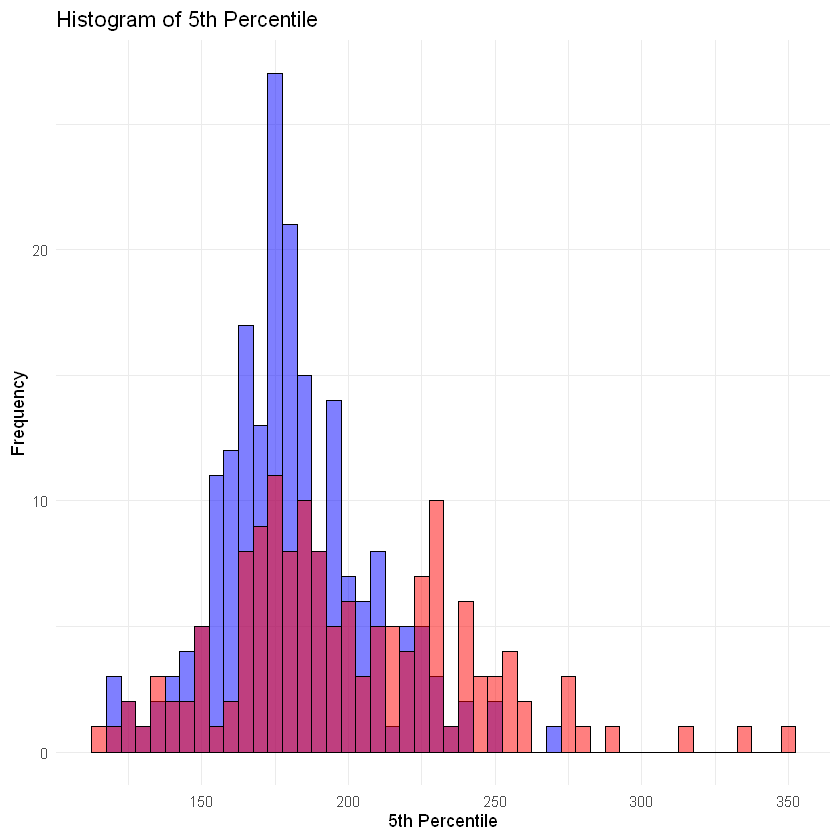

In [31]:
# First histogram for urban data
p <- ggplot(urban_scaled, aes(x = X5th.Percentile)) +
  geom_histogram(binwidth = 5, fill = "blue", color = "black", alpha = 0.5) +
  labs(title = "Histogram of 5th Percentile", x = "5th Percentile", y = "Frequency") +
  theme_minimal()

# Add the rural histogram
p + geom_histogram(data = rural_scaled, aes(x = X5th.Percentile), 
                   binwidth = 5, fill = "red", color = "black", alpha = 0.5)

In [32]:
# Keep only rows where X5th.Percentile is less than 500
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X5th.Percentile < 300, ]
urban_scaled <- urban_scaled[urban_scaled$X5th.Percentile < 300, ]
rural_scaled <- rural_scaled[rural_scaled$X5th.Percentile < 300, ]

# Keep only rows where X50.Percentile is less than 500
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X50th.Percentile < 750, ]
urban_scaled <- urban_scaled[urban_scaled$X50th.Percentile < 750, ]
rural_scaled <- rural_scaled[rural_scaled$X50th.Percentile < 750, ]

# Keep only rows where X95.Percentile is less than 750
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X95th.Percentile < 750, ]
urban_scaled <- urban_scaled[urban_scaled$X95th.Percentile < 750, ]
rural_scaled <- rural_scaled[rural_scaled$X95th.Percentile < 750, ]

### visualise against certain significant variables

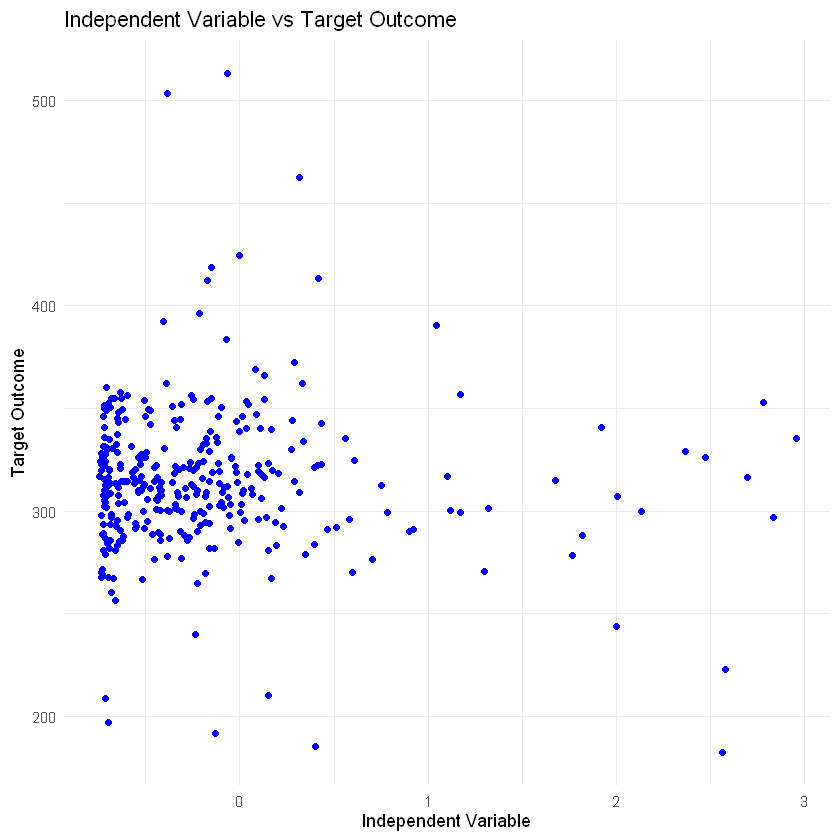

In [24]:
ggplot(cleaned_scaled, aes(x = closest_capital_distance, y = X50th.Percentile)) +
  geom_point(color = "blue") +
  labs(title = "Independent Variable vs Target Outcome", x = "Independent Variable", y = "Target Outcome") +
  theme_minimal()

## W Statistics

In [12]:
# Ensure only numeric columns are included for the Shapiro-Wilk test
numeric_data <- cleaned_data[sapply(cleaned_data, is.numeric)]

# Perform the Shapiro-Wilk normality test on each numeric column
normality_test_results <- apply(numeric_data, 2, function(x) shapiro.test(x))

# Extract the p-values and W-statistics
normality_table <- data.frame(
  Column = colnames(numeric_data),
  W_Statistic = sapply(normality_test_results, function(x) x$statistic),
  P_Value = sapply(normality_test_results, function(x) x$p.value)
)

# Format and print the table
library(knitr)
kable(normality_table, caption = "Shapiro-Wilk Normality Test Results")




Table: Shapiro-Wilk Normality Test Results

|                            |Column                    | W_Statistic|   P_Value|
|:---------------------------|:-------------------------|-----------:|---------:|
|lga_code.W                  |lga_code                  |   0.9291681| 0.0000000|
|IRSD.Decile.W               |IRSD.Decile               |   0.9369648| 0.0000000|
|IRSAD.Decile.W              |IRSAD.Decile              |   0.9331790| 0.0000000|
|IER.Decile.W                |IER.Decile                |   0.9368728| 0.0000000|
|IEO.Decile.W                |IEO.Decile                |   0.9335257| 0.0000000|
|Median.Income.W             |Median.Income             |   0.9185662| 0.0000000|
|Lowest.Quartile.Income...W  |Lowest.Quartile.Income..  |   0.9884560| 0.0029175|
|Highest.Quartile.Income...W |Highest.Quartile.Income.. |   0.9174815| 0.0000000|
|Gini.Coefficient.W          |Gini.Coefficient          |   0.8888074| 0.0000000|
|Area..Km.2..W               |Area..Km.2.           

## Assumptions of Ridge Regression

 lag Autocorrelation D-W Statistic p-value
   1     -0.00534075      1.987728     0.8
 Alternative hypothesis: rho != 0


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


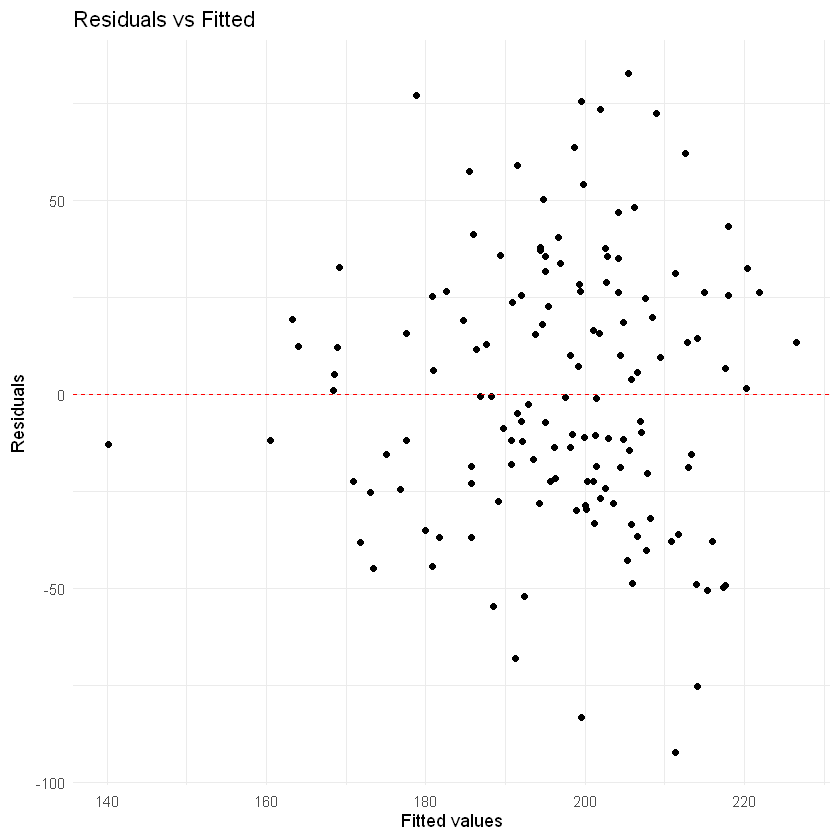

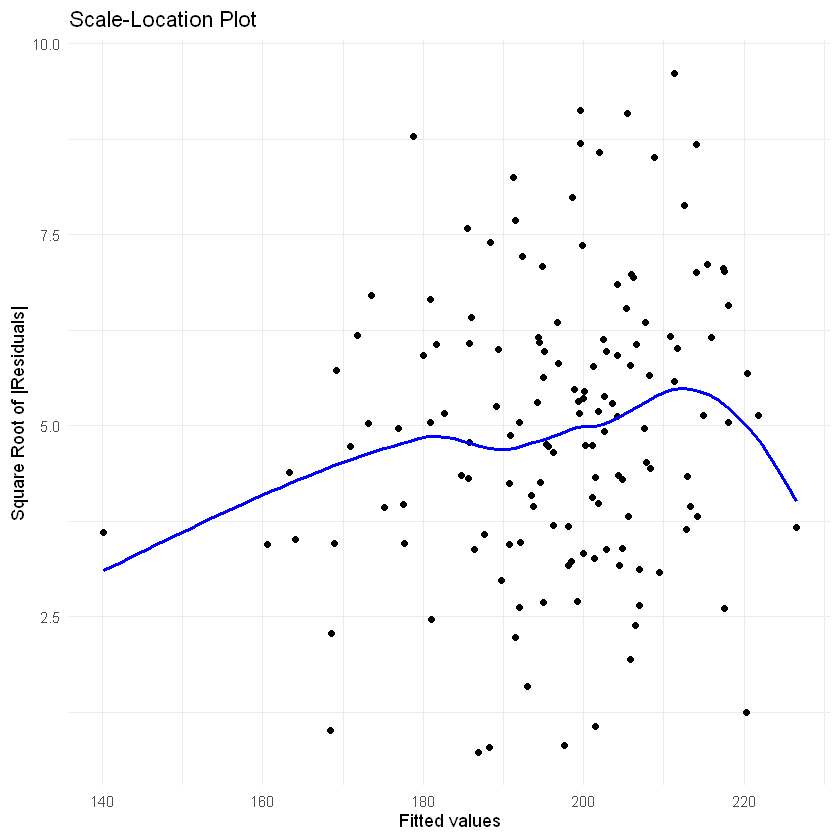


	Shapiro-Wilk normality test

data:  lm_model$residuals
W = 0.99168, p-value = 0.5661



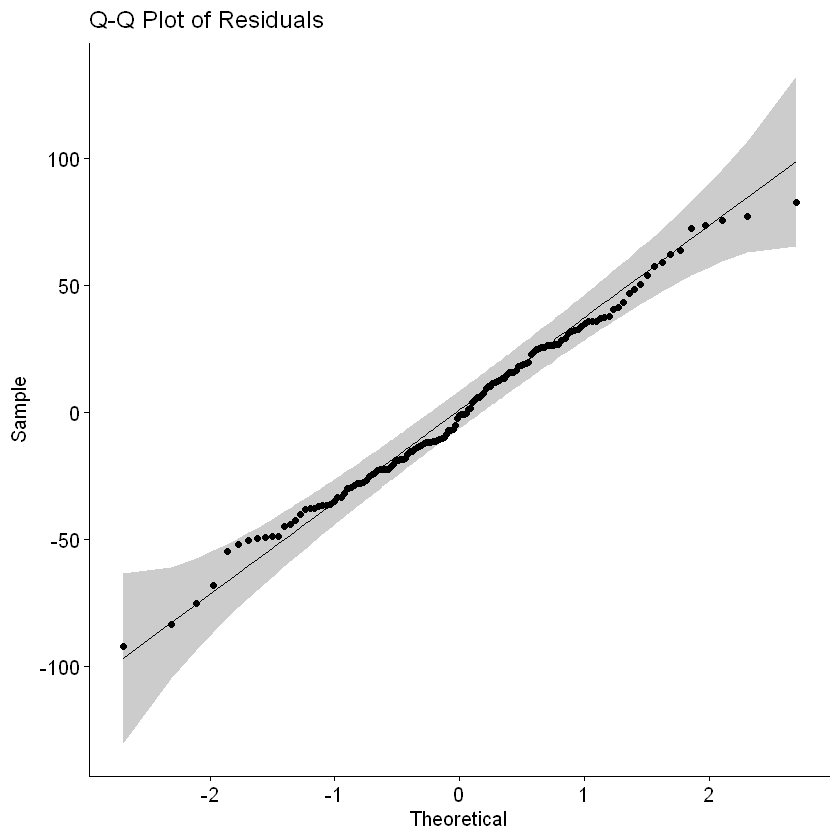

In [43]:
# Load necessary libraries
library(ggplot2)
library(car)  # For the Durbin-Watson test
library(ggpubr)  # For ggqqplot

# Assuming you have a response variable and predictors in cleaned_scaled
response <- "X5th.Percentile"  # Replace with your actual response variable name
predictors <- names(rural_scaled)[names(rural_scaled) != response]
# Remove specified elements
predictors <- setdiff(predictors, c("X50th.Percentile", "X95th.Percentile", "X95th.5th.Ratio"))


# Fit a linear model for diagnostics
lm_model <- lm(as.formula(paste(response, "~", paste(predictors, collapse = "+"))), data = rural_scaled)

# 1. Linearity - Residuals vs Fitted
ggplot(data = lm_model, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Residuals vs Fitted", x = "Fitted values", y = "Residuals") +
  theme_minimal()

# 2. Independence - Durbin-Watson test
dw_test <- durbinWatsonTest(lm_model)
print(dw_test)

# 3. Homoscedasticity - Scale-Location Plot
ggplot(data = lm_model, aes(x = .fitted, y = sqrt(abs(.resid)))) +
  geom_point() +
  geom_smooth(se = FALSE, color = "blue") +
  labs(title = "Scale-Location Plot", x = "Fitted values", y = "Square Root of |Residuals|") +
  theme_minimal()

# 4. Normality - Q-Q Plot
ggqqplot(lm_model$residuals) +
  labs(title = "Q-Q Plot of Residuals")

# 5. Shapiro-Wilk test for normality of residuals
shapiro_test <- shapiro.test(lm_model$residuals)
print(shapiro_test)
